# Traffic Signs Classification with CNN

## Related Paper
Sichkar V. N., Kolyubin S. A. Effect of various dimension convolutional layer filters on traffic sign classification accuracy. *Scientific and Technical Journal of Information Technologies, Mechanics and Optics*, 2019, vol. 19, no. 3, pp. DOI: 10.17586/2226-1494-2019-19-3-546-552 (Full-text available on ResearchGate here: [Effect of various dimension convolutional layer filters on traffic sign classification accuracy](https://www.researchgate.net/publication/334074308_Effect_of_various_dimension_convolutional_layer_filters_on_traffic_sign_classification_accuracy))

$\displaystyle ^*$ Experiments in the paper were done with pure numpy library and in different machine. Some results might be different. But main concept is implemented in this Notebook with Keras and can be repeated with ease or used for further research.

$\displaystyle ^*$ Test online with custom Traffic Sign here: https://valentynsichkar.name/traffic_signs.html

## Related Course for Detection Tasks
**Training YOLO v3 for Objects Detection with Custom Data.** *Build your own detector by labelling, training and testing on image, video and in real time with camera.* Available here: [https://www.udemy.com/course/training-yolo-v3-for-objects-detection-with-custom-data/](https://www.udemy.com/course/training-yolo-v3-for-objects-detection-with-custom-data/?referralCode=A283956A57327E37DDAD)

Detections on video are shown below. **Trained weights** can be found in the course mentioned above.

![Video](https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F3400968%2Fbcdae0b57021d6ac3e86a9aa2e8c4b08%2Fts_detections.gif?generation=1581700736851192&alt=media "Detections of Traffic Signs on Video")

# Importing needed libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pickle
import matplotlib.pyplot as plt
from math import sqrt, ceil
from timeit import default_timer as timer

from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, AvgPool2D, BatchNormalization, Reshape
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('../input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

print(os.listdir('../input'))

# Any results we write to the current directory are saved as output


../input/traffic-signs-preprocessed/mean_image_gray.pickle
../input/traffic-signs-preprocessed/data2.pickle
../input/traffic-signs-preprocessed/data0.pickle
../input/traffic-signs-preprocessed/std_gray.pickle
../input/traffic-signs-preprocessed/data4.pickle
../input/traffic-signs-preprocessed/data3.pickle
../input/traffic-signs-preprocessed/test.pickle
../input/traffic-signs-preprocessed/data8.pickle
../input/traffic-signs-preprocessed/mean_image_rgb.pickle
../input/traffic-signs-preprocessed/valid.pickle
../input/traffic-signs-preprocessed/datasets_preparing.py
../input/traffic-signs-preprocessed/data1.pickle
../input/traffic-signs-preprocessed/data7.pickle
../input/traffic-signs-preprocessed/data5.pickle
../input/traffic-signs-preprocessed/std_rgb.pickle
../input/traffic-signs-preprocessed/label_names.csv
../input/traffic-signs-preprocessed/labels.pickle
../input/traffic-signs-preprocessed/train.pickle
../input/traffic-signs-preprocessed/data6.pickle
['traffic-signs-preprocessed']


# Loading dataset data2.pickle with RGB examples

In [2]:
# Opening file for reading in binary mode
with open('../input/traffic-signs-preprocessed/data2.pickle', 'rb') as f:
    data = pickle.load(f, encoding='latin1')  # dictionary type

# Preparing y_train and y_validation for using in Keras
data['y_train'] = to_categorical(data['y_train'], num_classes=43)
data['y_validation'] = to_categorical(data['y_validation'], num_classes=43)

# Making channels come at the end
data['x_train'] = data['x_train'].transpose(0, 2, 3, 1)
data['x_validation'] = data['x_validation'].transpose(0, 2, 3, 1)
data['x_test'] = data['x_test'].transpose(0, 2, 3, 1)

# Showing loaded data from file
for i, j in data.items():
    if i == 'labels':
        print(i + ':', len(j))
    else: 
        print(i + ':', j.shape)

# x_train: (86989, 32, 32, 3)
# y_train: (86989, 43)
# x_test: (12630, 32, 32, 3)
# y_test: (12630,)
# x_validation: (4410, 32, 32, 3)
# y_validation: (4410, 43)
# labels: 43


y_test: (12630,)
y_validation: (4410, 43)
x_validation: (4410, 32, 32, 3)
x_train: (86989, 32, 32, 3)
y_train: (86989, 43)
labels: 43
x_test: (12630, 32, 32, 3)


# Showing some examples

(81, 32, 32, 3)


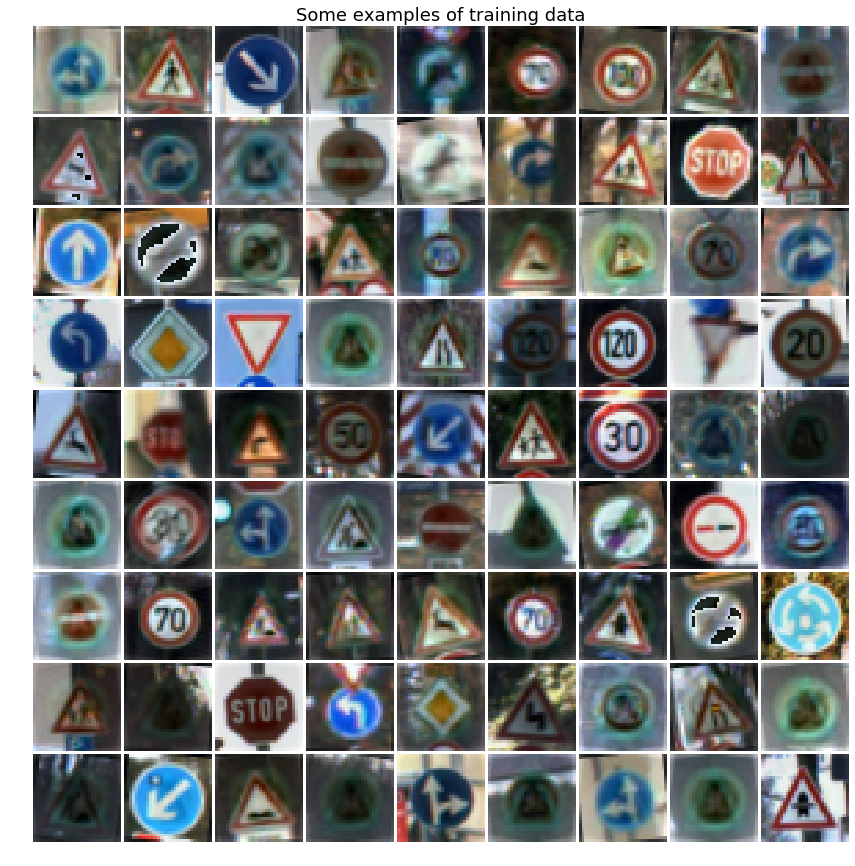

In [3]:
%matplotlib inline

# Preparing function for ploting set of examples
# As input it will take 4D tensor and convert it to the grid
# Values will be scaled to the range [0, 255]
def convert_to_grid(x_input):
    N, H, W, C = x_input.shape
    grid_size = int(ceil(sqrt(N)))
    grid_height = H * grid_size + 1 * (grid_size - 1)
    grid_width = W * grid_size + 1 * (grid_size - 1)
    grid = np.zeros((grid_height, grid_width, C)) + 255
    next_idx = 0
    y0, y1 = 0, H
    for y in range(grid_size):
        x0, x1 = 0, W
        for x in range(grid_size):
            if next_idx < N:
                img = x_input[next_idx]
                low, high = np.min(img), np.max(img)
                grid[y0:y1, x0:x1] = 255.0 * (img - low) / (high - low)
                next_idx += 1
            x0 += W + 1
            x1 += W + 1
        y0 += H + 1
        y1 += H + 1

    return grid


# Visualizing some examples of training data
examples = data['x_train'][:81, :, :, :]
print(examples.shape)  # (81, 32, 32, 3)

# Plotting some examples
fig = plt.figure()
grid = convert_to_grid(examples)
plt.imshow(grid.astype('uint8'), cmap='gray')
plt.axis('off')
plt.gcf().set_size_inches(15, 15)
plt.title('Some examples of training data', fontsize=18)

# Showing the plot
plt.show()

# Saving the plot
fig.savefig('training_examples.png')
plt.close()


# Building model of CNN with Keras
## Trying one model with filters of size 3x3

In [4]:
model = Sequential()
model.add(Conv2D(32, kernel_size=3, padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPool2D(pool_size=2))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dense(43, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# Overfitting small data

In [5]:
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** (x + epochs))
epochs = 15

h = model.fit(data['x_train'][:10], data['y_train'][:10],
              batch_size=5, epochs = epochs,
              validation_data = (data['x_validation'], data['y_validation']),
              callbacks=[annealer], verbose=1)


Train on 10 samples, validate on 4410 samples
Epoch 1/15
10/10 [==============================] - 9s 887ms/step - loss: 3.7862 - acc: 0.0000e+00 - val_loss: 3.8558 - val_acc: 0.0324
Epoch 2/15
10/10 [==============================] - 1s 139ms/step - loss: 2.8585 - acc: 0.3000 - val_loss: 4.1659 - val_acc: 0.0354
Epoch 3/15
10/10 [==============================] - 1s 133ms/step - loss: 2.3046 - acc: 0.6000 - val_loss: 4.6272 - val_acc: 0.0397
Epoch 4/15
10/10 [==============================] - 1s 131ms/step - loss: 1.8685 - acc: 0.5000 - val_loss: 5.1597 - val_acc: 0.0410
Epoch 5/15
10/10 [==============================] - 1s 132ms/step - loss: 1.5313 - acc: 0.5000 - val_loss: 5.7040 - val_acc: 0.0431
Epoch 6/15
10/10 [==============================] - 1s 135ms/step - loss: 1.3001 - acc: 0.7000 - val_loss: 6.2078 - val_acc: 0.0426
Epoch 7/15
10/10 [==============================] - 1s 135ms/step - loss: 1.0863 - acc: 0.9000 - val_loss: 6.6593 - val_acc: 0.0406
Epoch 8/15
10/10 [========

In [6]:
print('Epochs={0:d}, training accuracy={1:.5f}, validation accuracy={2:.5f}'.\
      format(epochs, max(h.history['acc']), max(h.history['val_acc'])))


Epochs=15, training accuracy=1.00000, validation accuracy=0.04830


# Plotting history results for overfitting small data

/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


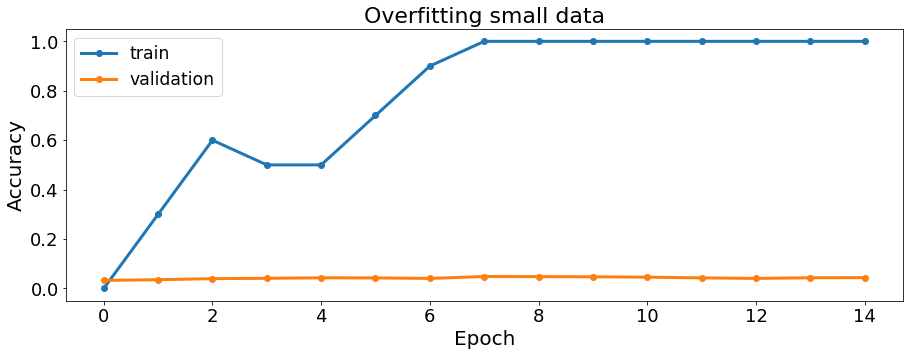

In [7]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 5.0) # Setting default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['font.family'] = 'Times New Roman'

fig = plt.figure()
plt.plot(h.history['acc'], '-o', linewidth=3.0)
plt.plot(h.history['val_acc'], '-o', linewidth=3.0)
plt.title('Overfitting small data', fontsize=22)
plt.legend(['train', 'validation'], loc='upper left', fontsize='xx-large')
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
plt.tick_params(labelsize=18)

# Showing the plot
plt.show()

# Saving the plot
fig.savefig('overfitting_small_data.png')
plt.close()


# Building set of models of CNN with Keras
## Trying different models with different dimensions of filters

In [8]:
filters = [3, 5, 9, 13, 15, 19, 23, 25, 31]
model = [0] * len(filters)

for i in range(len(model)):
    model[i] = Sequential()
    model[i].add(Conv2D(32, kernel_size=filters[i], padding='same', activation='relu', input_shape=(32, 32, 3)))
    model[i].add(MaxPool2D(pool_size=2))
    model[i].add(Flatten())
    model[i].add(Dense(500, activation='relu'))
    model[i].add(Dense(43, activation='softmax'))
    model[i].compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# Training set of models of CNN with Keras
## And with different dimensions of filters

In [9]:
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** (x + epochs))
epochs = 5

h = [0] * len(model)

for i in range(len(h)):
    h[i] = model[i].fit(data['x_train'], data['y_train'],
                        batch_size=5, epochs = epochs,
                        validation_data = (data['x_validation'], data['y_validation']),
                        callbacks=[annealer], verbose=0)
    
    print('Model with filters {0:d}x{0:d}, epochs={1:d}, training accuracy={2:.5f}, validation accuracy={3:.5f}'.\
      format(filters[i], epochs, max(h[i].history['acc']), max(h[i].history['val_acc'])))


Model with filters 3x3, epochs=5, training accuracy=0.98823, validation accuracy=0.88118
Model with filters 5x5, epochs=5, training accuracy=0.98593, validation accuracy=0.87891
Model with filters 9x9, epochs=5, training accuracy=0.98122, validation accuracy=0.86009
Model with filters 13x13, epochs=5, training accuracy=0.97353, validation accuracy=0.85941
Model with filters 15x15, epochs=5, training accuracy=0.96754, validation accuracy=0.84014
Model with filters 19x19, epochs=5, training accuracy=0.96066, validation accuracy=0.82041
Model with filters 23x23, epochs=5, training accuracy=0.95267, validation accuracy=0.82290
Model with filters 25x25, epochs=5, training accuracy=0.94330, validation accuracy=0.83900
Model with filters 31x31, epochs=5, training accuracy=0.93122, validation accuracy=0.82653


# Plotting comparison results for accuracy

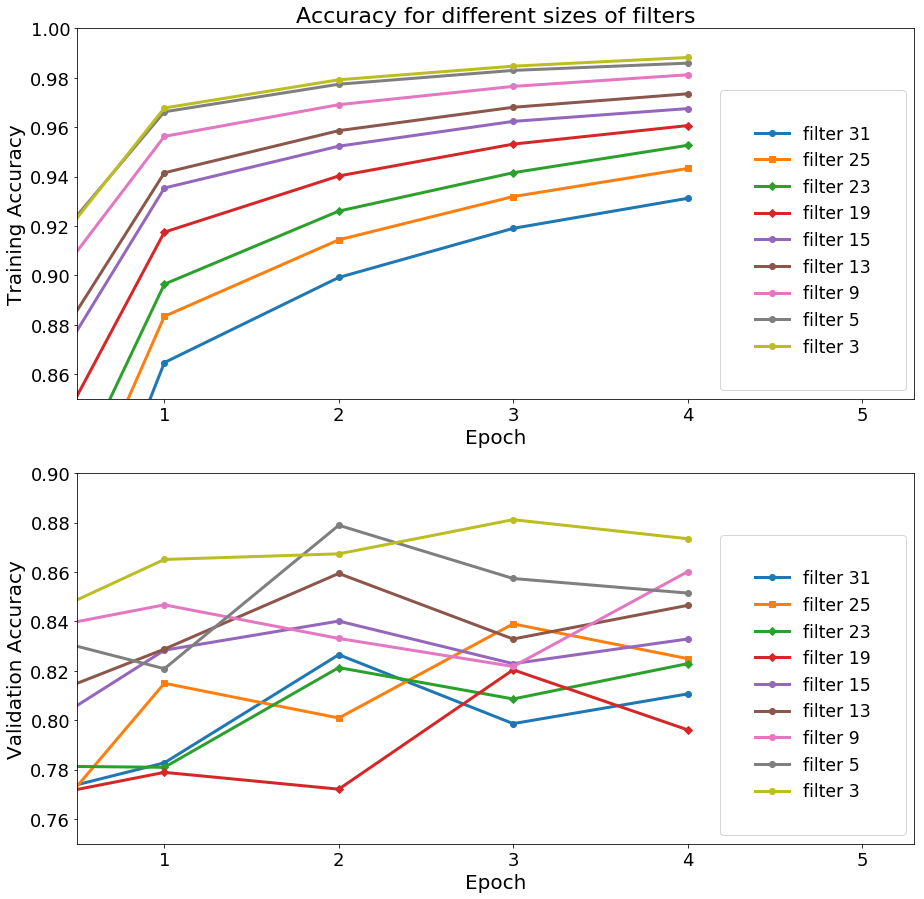

data2 filter 3 training accuracy = 0.98823
data2 filter 5 training accuracy = 0.98593
data2 filter 9 training accuracy = 0.98122
data2 filter 13 training accuracy = 0.97353
data2 filter 15 training accuracy = 0.96754
data2 filter 19 training accuracy = 0.96066
data2 filter 23 training accuracy = 0.95267
data2 filter 25 training accuracy = 0.94330
data2 filter 31 training accuracy = 0.93122

data2 filter 3 validation accuracy = 0.88118
data2 filter 5 validation accuracy = 0.87891
data2 filter 9 validation accuracy = 0.86009
data2 filter 13 validation accuracy = 0.85941
data2 filter 15 validation accuracy = 0.84014
data2 filter 19 validation accuracy = 0.82041
data2 filter 23 validation accuracy = 0.82290
data2 filter 25 validation accuracy = 0.83900
data2 filter 31 validation accuracy = 0.82653


In [10]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 15.0) # Setting default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['font.family'] = 'Times New Roman'

# Plotting history of training accuracy
fig = plt.figure()
plt.subplot(2, 1, 1)
plt.plot(h[8].history['acc'], '-o', linewidth=3.0)
plt.plot(h[7].history['acc'], '-s', linewidth=3.0)
plt.plot(h[6].history['acc'], '-D', linewidth=3.0)
plt.plot(h[5].history['acc'], '-D', linewidth=3.0)
plt.plot(h[4].history['acc'], '-o', linewidth=3.0)
plt.plot(h[3].history['acc'], '-o', linewidth=3.0)
plt.plot(h[2].history['acc'], '-o', linewidth=3.0)
plt.plot(h[1].history['acc'], '-o', linewidth=3.0)
plt.plot(h[0].history['acc'], '-o', linewidth=3.0)
plt.legend(['filter 31', 'filter 25', 'filter 23', 'filter 19', 'filter 15', 'filter 13', 'filter 9', 'filter 5', 'filter 3'], loc='lower right', fontsize='xx-large', borderpad=2)
plt.xlabel('Epoch', fontsize=20, fontname='Times New Roman')
plt.ylabel('Training Accuracy', fontsize=20, fontname='Times New Roman')
plt.yscale('linear')  # {"linear", "log", "symlog", "logit", ...}
plt.ylim(0.85, 1.0)
plt.xlim(0.5, 5.3) 
plt.title('Accuracy for different sizes of filters', fontsize=22)
plt.tick_params(labelsize=18)

plt.subplot(2, 1, 2)
# plt.gca().set_title('Validation accuracy')
plt.plot(h[8].history['val_acc'], '-o', linewidth=3.0)
plt.plot(h[7].history['val_acc'], '-s', linewidth=3.0)
plt.plot(h[6].history['val_acc'], '-D', linewidth=3.0)
plt.plot(h[5].history['val_acc'], '-D', linewidth=3.0)
plt.plot(h[4].history['val_acc'], '-o', linewidth=3.0)
plt.plot(h[3].history['val_acc'], '-o', linewidth=3.0)
plt.plot(h[2].history['val_acc'], '-o', linewidth=3.0)
plt.plot(h[1].history['val_acc'], '-o', linewidth=3.0)
plt.plot(h[0].history['val_acc'], '-o', linewidth=3.0)
plt.legend(['filter 31', 'filter 25', 'filter 23', 'filter 19', 'filter 15', 'filter 13', 'filter 9', 'filter 5', 'filter 3'], loc='lower right', fontsize='xx-large', borderpad=2)
plt.xlabel('Epoch', fontsize=20, fontname='Times New Roman')
plt.ylabel('Validation Accuracy', fontsize=20, fontname='Times New Roman')
plt.yscale('linear')  # {"linear", "log", "symlog", "logit", ...}
plt.ylim(0.75, 0.9)
plt.xlim(0.5, 5.3)
plt.tick_params(labelsize=18)

# Showing the plot
plt.show()

# Saving the plot
fig.savefig('models_accuracy.png')
plt.close()


# Showing values of accuracy for different filters
for i in range(len(h)):
    print('data2 filter {0:d} training accuracy = {1:.5f}'.\
          format(filters[i], np.max(h[i].history['acc'])))

print()

for i in range(len(h)):
    print('data2 filter {0:d} validation accuracy = {1:.5f}'.\
          format(filters[i], np.max(h[i].history['val_acc'])))


# Calculating accuracy with testing dataset

In [11]:
for i in range(len(model)):
    temp = model[i].predict(data['x_test'])
    temp = np.argmax(temp, axis=1)

    # We compare predicted class with correct class for all input images
    # And calculating mean value among all values of following numpy array
    # By saying 'testing_accuracy == data['y_test']' we create numpy array with True and False values
    # 'np.mean' function will return average of the array elements
    # The average is taken over the flattened array by default
    temp = np.mean(temp == data['y_test'])
    
    print('data2 filter {0:d} testing accuracy = {1:.5f}'.format(filters[i], temp))


data2 filter 3 testing accuracy = 0.87165
data2 filter 5 testing accuracy = 0.86112
data2 filter 9 testing accuracy = 0.86010
data2 filter 13 testing accuracy = 0.86136
data2 filter 15 testing accuracy = 0.84497
data2 filter 19 testing accuracy = 0.82367
data2 filter 23 testing accuracy = 0.84260
data2 filter 25 testing accuracy = 0.84133
data2 filter 31 testing accuracy = 0.81496


# Time for classification

In [12]:
# Getting scores from forward pass of one input image
# Scores are given for each image with 43 numbers of predictions for each class
# Measuring at the same time execution time

for i in range(len(model)):
    start = timer()
    temp = model[i].predict(data['x_test'][:1, :, :, :])
    end = timer()
    
    print('data2 filter {0:d} classification time = {1:.5f}'.format(filters[i], end - start))


data2 filter 3 classification time = 0.00965
data2 filter 5 classification time = 0.00964
data2 filter 9 classification time = 0.00421
data2 filter 13 classification time = 0.00493
data2 filter 15 classification time = 0.00445
data2 filter 19 classification time = 0.00548
data2 filter 23 classification time = 0.00753
data2 filter 25 classification time = 0.00750
data2 filter 31 classification time = 0.01946


# Visualizing filters of convolutional layer

(3, 3, 3, 32)
(32, 3, 3, 3)


/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


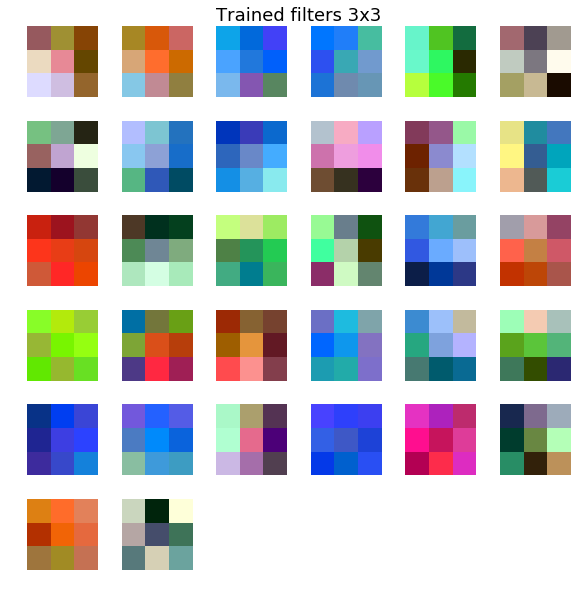

(5, 5, 3, 32)
(32, 5, 5, 3)


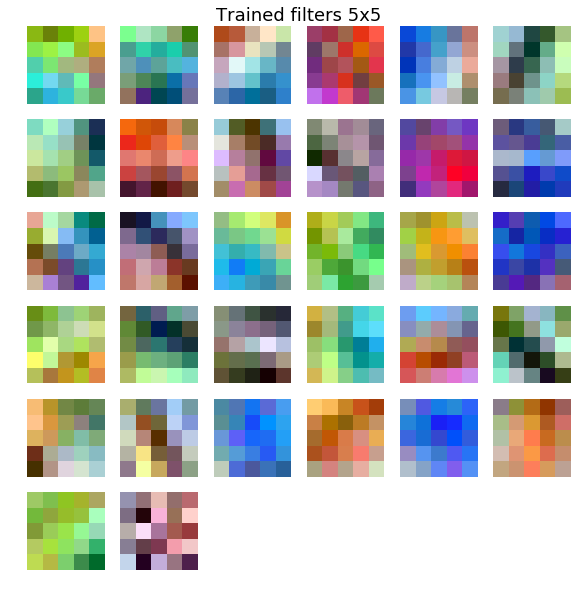

(9, 9, 3, 32)
(32, 9, 9, 3)


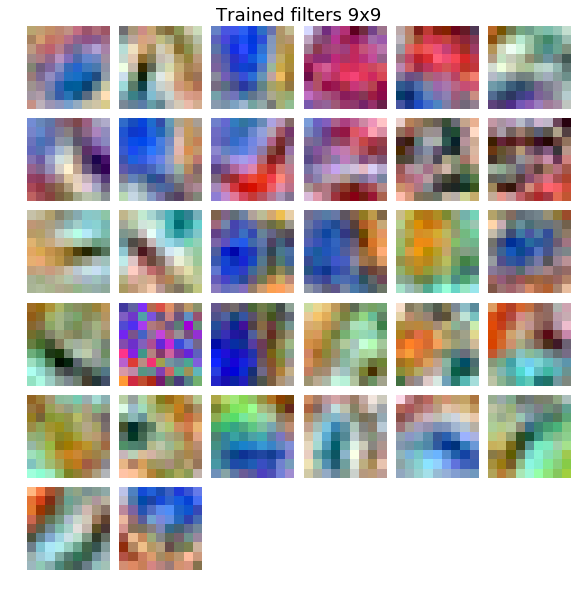

(13, 13, 3, 32)
(32, 13, 13, 3)


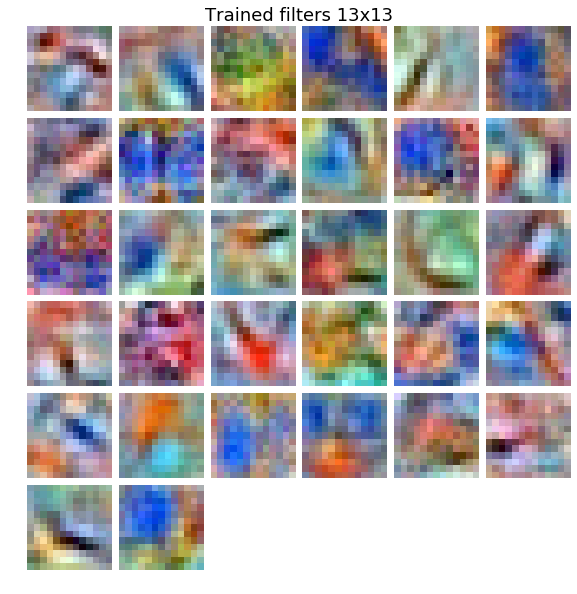

(15, 15, 3, 32)
(32, 15, 15, 3)


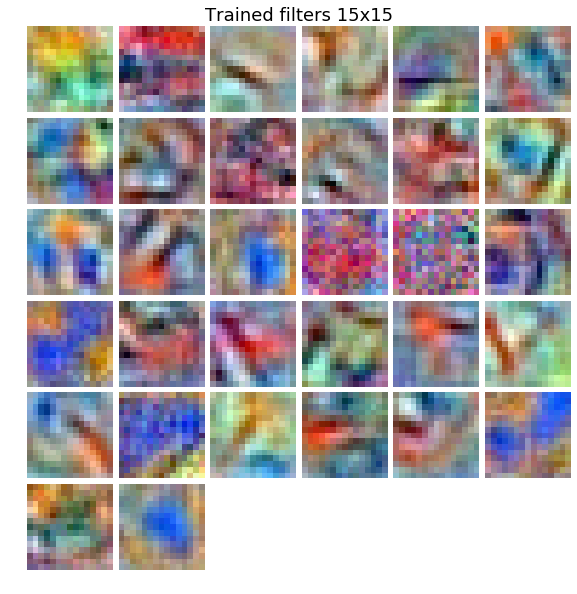

(19, 19, 3, 32)
(32, 19, 19, 3)


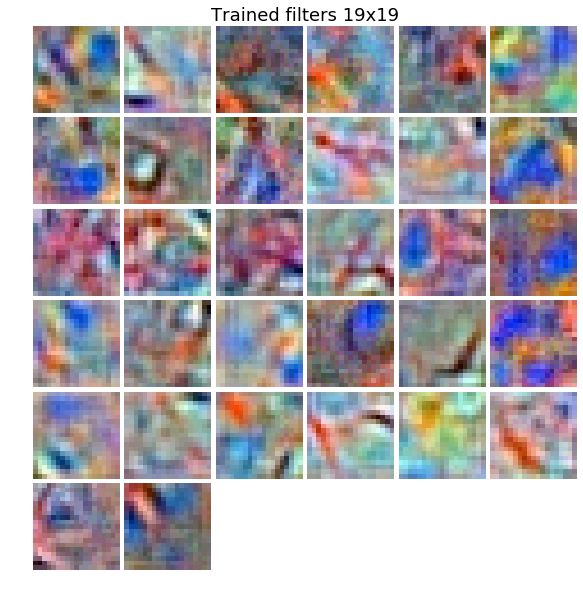

(23, 23, 3, 32)
(32, 23, 23, 3)


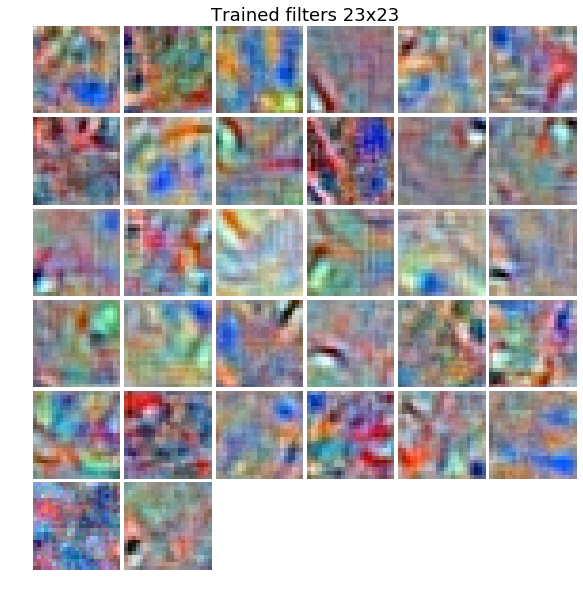

(25, 25, 3, 32)
(32, 25, 25, 3)


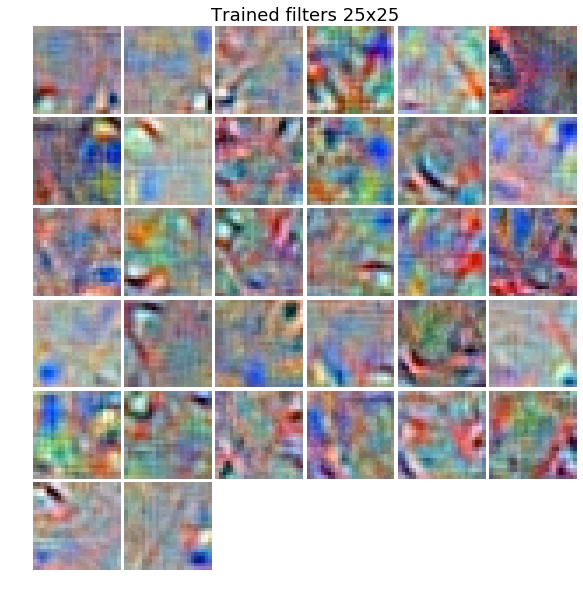

(31, 31, 3, 32)
(32, 31, 31, 3)


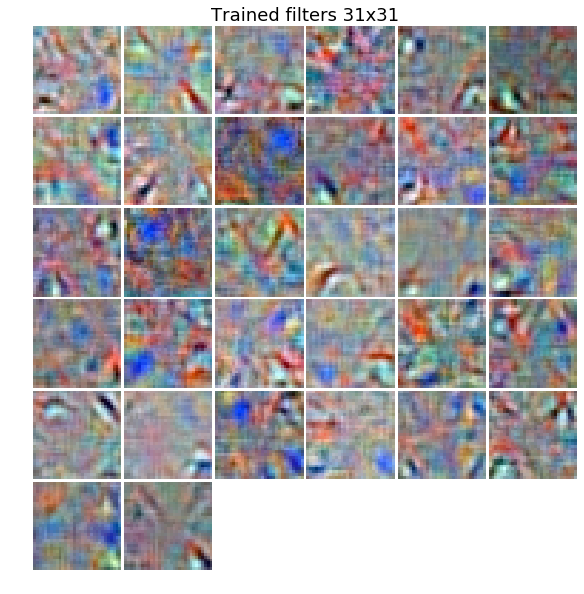

In [13]:
for i in range(len(model)):
    w = model[i].get_weights()
    print(w[0].shape)
    # print(model[i].get_config())
    # l = model[i].layers
    # print(l[0].get_weights()[0].shape)

    # Visualizing filters
    temp = w[0].transpose(3, 0, 1, 2)
    print(temp.shape)  # (81, 32, 32, 3)

    # Plotting
    fig = plt.figure()
    grid = convert_to_grid(temp)
    plt.imshow(grid.astype('uint8'), cmap='gray')
    plt.axis('off')
    plt.gcf().set_size_inches(10, 10)
    name = 'Trained filters ' + str(filters[i]) + 'x' + str(filters[i])
    plt.title(name, fontsize=18)
    
    # Showing the plot
    plt.show()

    # Saving the plot
    name = 'filters-' + str(filters[i]) + 'x' + str(filters[i]) + '.png'
    fig.savefig(name)
    plt.close()


# Predicting with one image from test dataset

(1, 32, 32, 3)
[3]


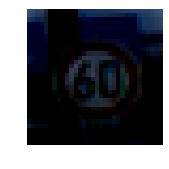

(43,)
ClassId: 3
Label: Speed limit (60km/h)


In [14]:
%matplotlib inline

# Preparing image for predicting from test dataset
x_input = data['x_test'][100:101]
print(x_input.shape)
y_input = data['y_test'][100:101]
print(y_input)

plt.rcParams['figure.figsize'] = (2.5, 2.5) # Setting default size of plots
plt.imshow(x_input[0, :, :, :])
plt.axis('off')

# Showing the plot
plt.show()

# Getting scores from forward pass of input image
scores = model[0].predict(x_input)
print(scores[0].shape) # (43,)

# Scores is given for image with 43 numbers of predictions for each class
# Getting only one class with maximum value
prediction = np.argmax(scores)
print('ClassId:', prediction)

# Defining function for getting texts for every class - labels
def label_text(file):
    # Defining list for saving label in order from 0 to 42
    label_list = []
    
    # Reading 'csv' file and getting image's labels
    r = pd.read_csv(file)
    # Going through all names
    for name in r['SignName']:
        # Adding from every row second column with name of the label
        label_list.append(name)
    
    # Returning resulted list with labels
    return label_list


# Getting labels
labels = label_text('../input/traffic-signs-preprocessed/label_names.csv')

# Printing label for classified Traffic Sign
print('Label:', labels[prediction])


# Saving models

In [15]:
for i in range(len(model)):
    name = 'model-' + str(filters[i]) + 'x' + str(filters[i]) + '.h5'
    model[i].save(name)

# # Saving model locally without committing
# from IPython.display import FileLink

# FileLink('model-3x3.h5')
